# OptiML Project - Text classification models optimization

## Imports

In [1]:
from pathlib import Path
import random
from collections import namedtuple, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import trange, tqdm
from transformers import BertTokenizer, BertModel

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Using GPU')
else:
    raise Exception('Using CPU')

Using GPU


## Setup the seed
For reproducibility purposes, we will set the seed of the random number generators

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)


seed = 42
seed_everything(seed)

## Load the data

In [4]:
dataset = load_dataset('cwchang/text-classification-dataset-example')
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'id'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['label', 'text', 'id'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['label', 'text', 'id'],
        num_rows: 7500
    })
})

In [5]:
pd.DataFrame(dataset['train'])

,label,text,id
0,book_flight,i need you to book me a flight from ft lauderd...,train-0
1,schedule_maintenance,my check engine light is on and i need to take...,train-1
2,reminder,is the company party on my list of reminders,train-2
3,are_you_a_bot,are you a human,train-3
4,todo_list_update,i need to do cleaning so add it to my to do list,train-4
...,...,...,...
14995,calculator,what is the square root of 10294,train-14995
14996,reminder_update,remind me again please,train-14996
14997,alarm,create an alarm for 6am,train-14997
14998,translate,how would i say pleased to meet you if i were ...,train-14998


### Split the data

In [6]:
"""test_size, val_size = 0.2, 0.2

split = dataset['train'].train_test_split(test_size=test_size, seed=seed, shuffle=True)
train_dataset = split['train']
test_dataset = split['test']
split = train_dataset.train_test_split(test_size=val_size, seed=seed, shuffle=True)
train_dataset = split['train']
val_dataset = split['test']"""
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['label', 'text', 'id'],
     num_rows: 15000
 }),
 Dataset({
     features: ['label', 'text', 'id'],
     num_rows: 3000
 }),
 Dataset({
     features: ['label', 'text', 'id'],
     num_rows: 7500
 }))

In [7]:
pd.DataFrame(train_dataset)

,label,text,id
0,book_flight,i need you to book me a flight from ft lauderd...,train-0
1,schedule_maintenance,my check engine light is on and i need to take...,train-1
2,reminder,is the company party on my list of reminders,train-2
3,are_you_a_bot,are you a human,train-3
4,todo_list_update,i need to do cleaning so add it to my to do list,train-4
...,...,...,...
14995,calculator,what is the square root of 10294,train-14995
14996,reminder_update,remind me again please,train-14996
14997,alarm,create an alarm for 6am,train-14997
14998,translate,how would i say pleased to meet you if i were ...,train-14998


In [8]:
pd.DataFrame(val_dataset)

,label,text,id
0,cook_time,how long should i cook steak for,eval-0
1,balance,please tell me how much money i have in my ban...,eval-1
2,gas,what is the gas level in my gas tank,eval-2
3,time,how late is it now in ourense,eval-3
4,car_rental,i really need to get a volkswagen car rental f...,eval-4
...,...,...,...
2995,current_location,please tell me the address of my current location,eval-2995
2996,replacement_card_duration,what is the eta on getting a replacement card,eval-2996
2997,change_volume,please turn your volume up,eval-2997
2998,improve_credit_score,show me a plan to help my credit score rating,eval-2998


In [9]:
pd.DataFrame(test_dataset)

,label,text,id
0,bill_balance,how much are my rent and cable,test-0
1,restaurant_suggestion,i need some suggestions for dinner places tonight,test-1
2,report_lost_card,can you report a lost card for me,test-2
3,timezone,timezone currently in mobile,test-3
4,what_is_your_name,tell me what to call you,test-4
...,...,...,...
7495,current_location,please tell me the address of my current location,eval-2995
7496,replacement_card_duration,what is the eta on getting a replacement card,eval-2996
7497,change_volume,please turn your volume up,eval-2997
7498,improve_credit_score,show me a plan to help my credit score rating,eval-2998


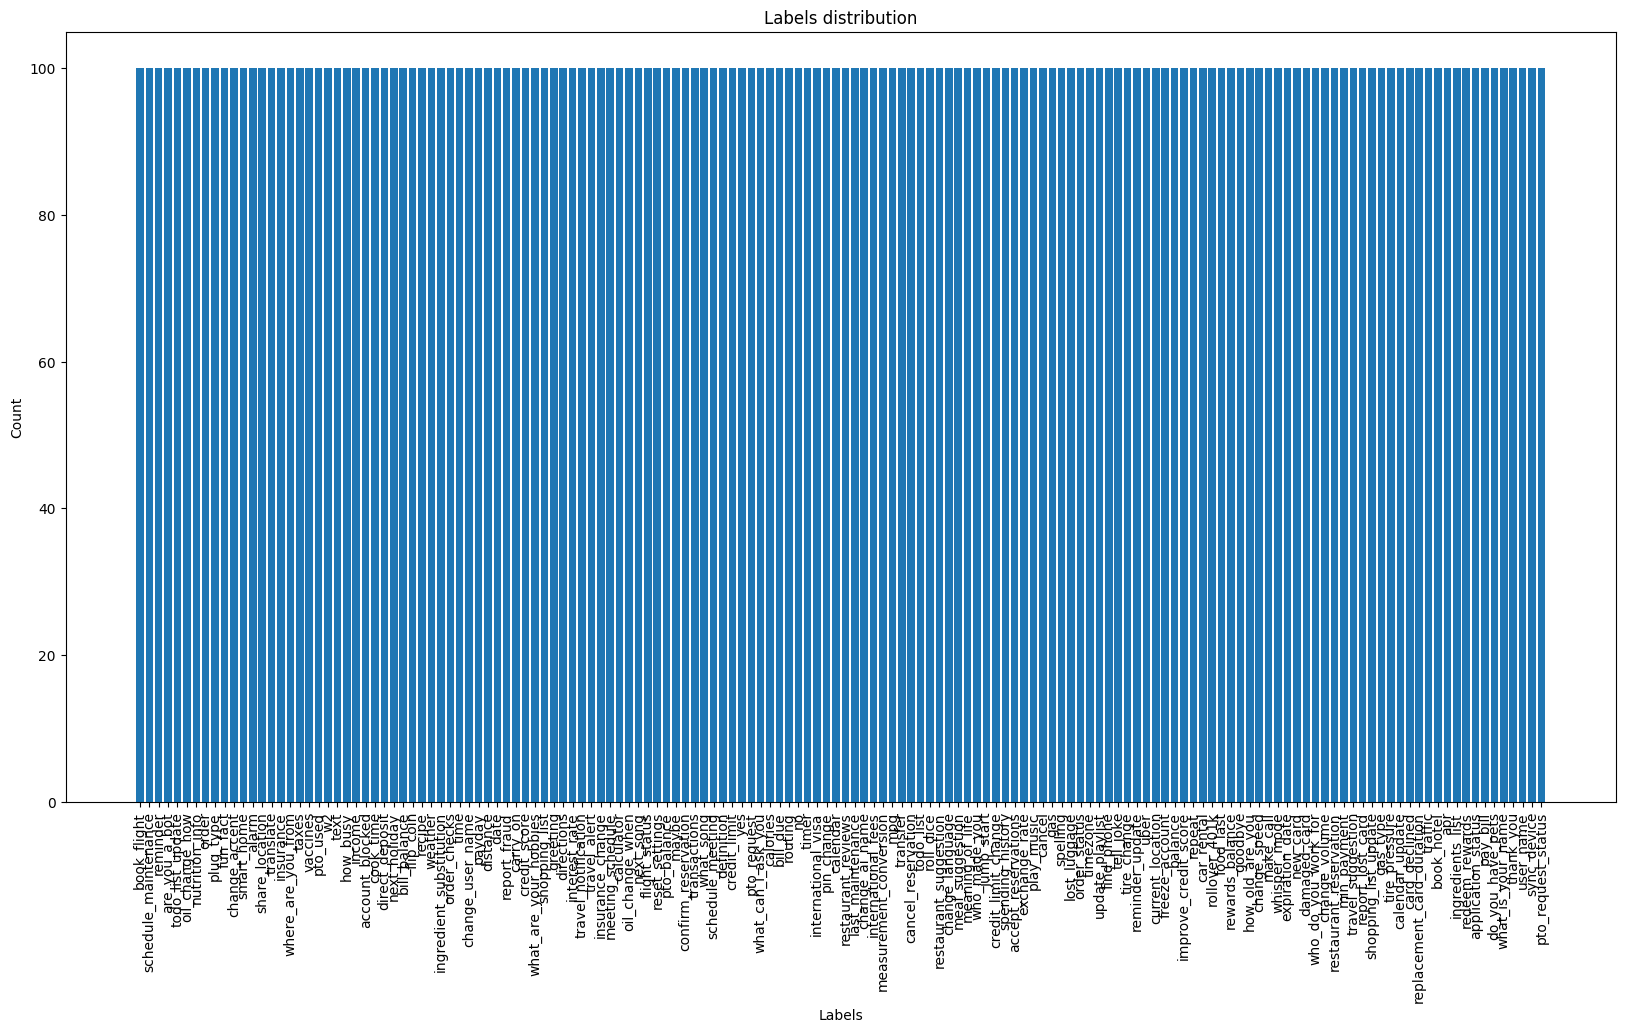

In [10]:
labels_counter = Counter([d['label'] for d in train_dataset])
plt.figure(figsize=(20, 10))
plt.bar(labels_counter.keys(), labels_counter.values())
plt.xticks(rotation=90)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Labels distribution')
plt.show()

In [11]:
classes = list(set(train_dataset['label']))
class2idx = {c: i for i, c in enumerate(classes)}
idx2class = {i: c for c, i in class2idx.items()}
num_classes = len(classes)
pd.DataFrame({'class': list(classes), 'idx': list(class2idx.values())})

,class,idx
0,pto_balance,0
1,freeze_account,1
2,application_status,2
3,make_call,3
4,restaurant_suggestion,4
...,...,...
145,mpg,145
146,food_last,146
147,distance,147
148,replacement_card_duration,148


In [12]:
num_classes

150

## Embeddings (BERT)
In this section we will use the Bert model to tokenize and perform contextual embedding on the text, we will then use simple models to classify the text.

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()


def tokenize(text):
    return tokenizer(text, padding=True, truncation=True, return_tensors='pt')


def embed_dataset(dataset):
    X = []
    y = []
    for d in tqdm(dataset):
        with torch.no_grad():
            inputs = tokenize(d['text'])
            outputs = bert_model(**inputs)
            X.append(outputs['last_hidden_state'].mean(dim=1).squeeze().cpu().numpy())
            y.append(class2idx[d['label']])
    return namedtuple('Embedding', ['X', 'y'])(np.array(X), np.array(y))

In [14]:
dataset_dir = Path('dataset')
if not dataset_dir.exists():
    # embed the dataset
    X_train, y_train = embed_dataset(train_dataset)
    X_val, y_val = embed_dataset(val_dataset)
    X_test, y_test = embed_dataset(test_dataset)

    # move to device
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor(y_val, dtype=torch.long).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.long).to(device)

    # save the dataset
    dataset_dir.mkdir()
    torch.save(X_train, dataset_dir / 'X_train.pt')
    torch.save(y_train, dataset_dir / 'y_train.pt')
    torch.save(X_val, dataset_dir / 'X_val.pt')
    torch.save(y_val, dataset_dir / 'y_val.pt')
    torch.save(X_test, dataset_dir / 'X_test.pt')
    torch.save(y_test, dataset_dir / 'y_test.pt')
else:
    # load the dataset
    X_train = torch.load(dataset_dir / 'X_train.pt')
    y_train = torch.load(dataset_dir / 'y_train.pt')
    X_val = torch.load(dataset_dir / 'X_val.pt')
    y_val = torch.load(dataset_dir / 'y_val.pt')
    X_test = torch.load(dataset_dir / 'X_test.pt')
    y_test = torch.load(dataset_dir / 'y_test.pt')

100%|██████████| 7500/7500 [05:56<00:00, 21.04it/s]


In [15]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

(torch.Size([15000, 768]),
 torch.Size([15000]),
 torch.Size([3000, 768]),
 torch.Size([3000]),
 torch.Size([7500, 768]),
 torch.Size([7500]))

In [16]:
train_dataloader = DataLoader(list(zip(X_train, y_train)), batch_size=32, shuffle=True)
val_dataloader = DataLoader(list(zip(X_val, y_val)), batch_size=32, shuffle=False)
test_dataloader = DataLoader(list(zip(X_test, y_test)), batch_size=32, shuffle=False)

In [17]:
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          scheduler: optim.lr_scheduler._LRScheduler,
          num_epochs: int):
    seed_everything(seed)
    if scheduler is None:
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1)
    t = trange(num_epochs)
    train_losses = []
    val_losses = []
    accs = []
    for epoch in t:
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        model.eval()
        acc, val_loss, _ = evaluate(model, val_dataloader, criterion)
        scheduler.step()
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accs.append(acc)
        t.set_postfix(train_loss=train_loss, val_loss=val_loss, acc=acc)
    return namedtuple('Training', ['train_losses', 'val_losses', 'accs'])(train_losses, val_losses, accs)


def plot_training(training):
    """
    Plot 2 different graphs : the training and validation losses and the validation accuracy
    :param training: namedtuple('Training', ['train_losses', 'val_losses', 'accs'])
    :return: None
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].plot(training.train_losses, label='Train loss')
    ax[0].plot(training.val_losses, label='Val loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training and validation losses')
    ax[0].legend()
    ax[1].plot(training.accs, label='Val accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Validation accuracy')
    ax[1].legend()
    plt.show()


def evaluate(model: nn.Module,
             test_dataloader: torch.utils.data.DataLoader,
             criterion: nn.Module):
    model.eval()
    confusion_matrix = np.zeros((num_classes, num_classes))
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()
            _, predicted = torch.max(y_pred, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            for i, j in zip(predicted, y_batch):
                confusion_matrix[i, j] += 1
    acc = correct / total
    test_loss /= len(test_dataloader)
    return namedtuple('Evaluation', ['accuracy', 'loss', 'confusion_matrix'])(acc, test_loss, confusion_matrix)


def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(30, 30))
    plt.imshow(confusion_matrix, cmap='Reds', interpolation='nearest')
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.show()

## Hyperparameters

In [18]:
criterion = nn.CrossEntropyLoss()
num_epochs = 50
learning_rate = 1e-3
_optimizer = optim.Adam

### Linear model
In this section we train the simpliest linear model to classify the text. Even if we know that it would be more efficient to solve it using the well known linear regression : `W = (X^T X)^{-1} X^T y`, we will make a gradient descent to show the convergence of the model with different customizations.
Ideas from Topic examples (project description):
- AdaGrad, Adam, SignSGD can you propose other optimizers
- Second order methods (Newton, ), 
- Learn learning rate schedules
- Along a training trajectory does the behavior of each step resemble the convexe case


In [19]:
model = nn.Linear(X_train.shape[1], num_classes).to(device)
optimizer = _optimizer(model.parameters(), lr=learning_rate)

100%|██████████| 50/50 [01:14<00:00,  1.48s/it, acc=0.938, train_loss=0.000479, val_loss=0.277]


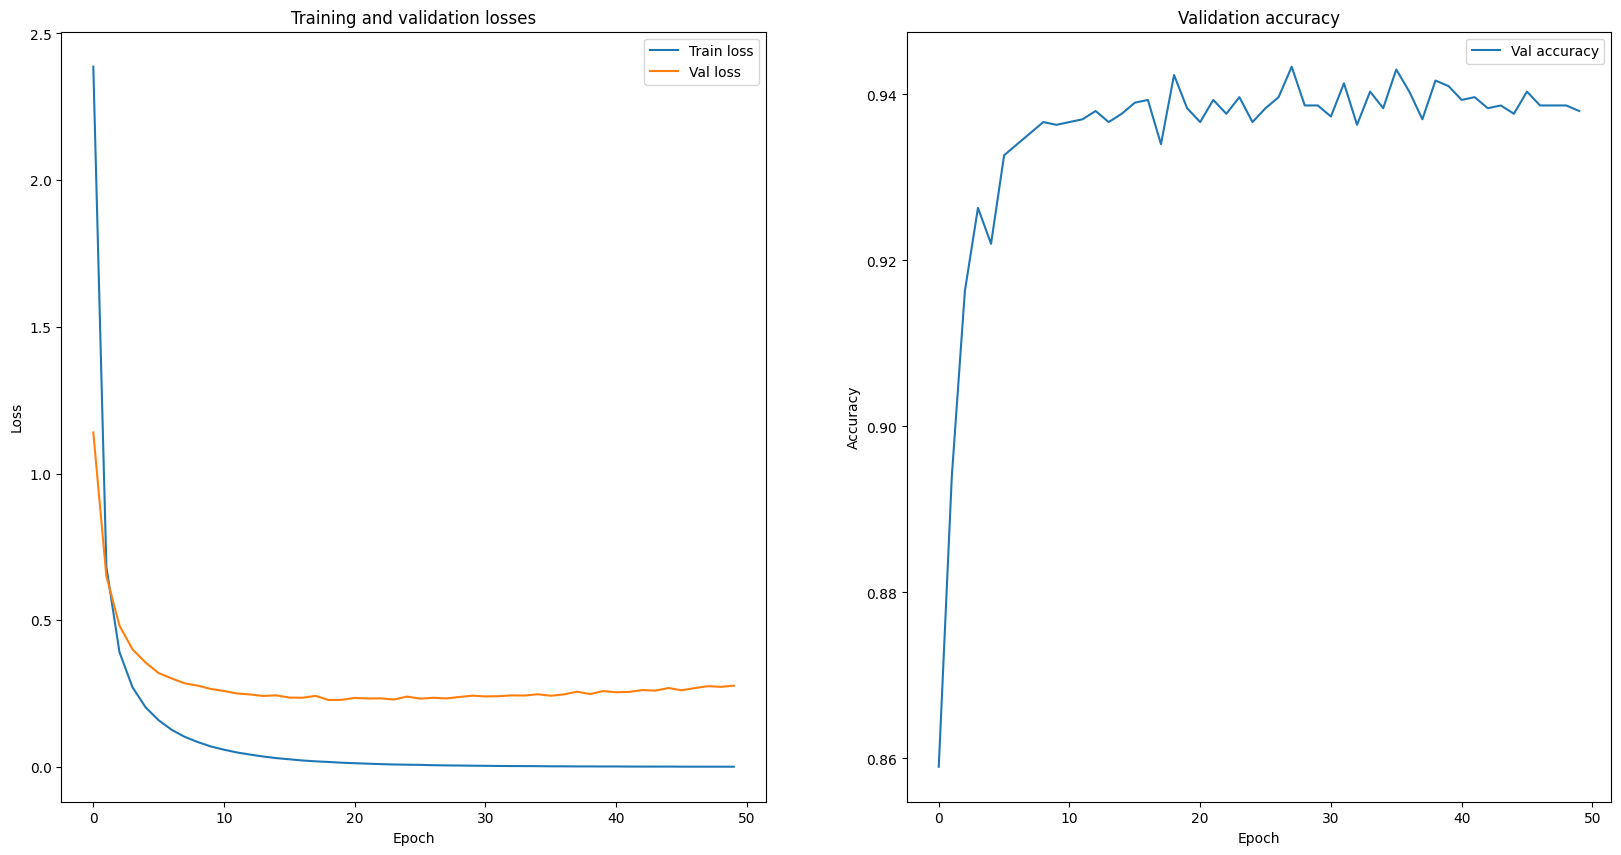

In [20]:
training = train(model=model,
                 train_dataloader=train_dataloader,
                 val_dataloader=val_dataloader,
                 optimizer=optimizer,
                 criterion=criterion,
                 scheduler=None,
                 num_epochs=num_epochs)
plot_training(training)

In [21]:
evaluation = evaluate(model, test_dataloader, criterion)
evaluation

Evaluation(accuracy=0.9349333333333333, loss=0.28954979215941806, confusion_matrix=array([[47.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 47.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 49., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 47.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 43.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 47.]]))

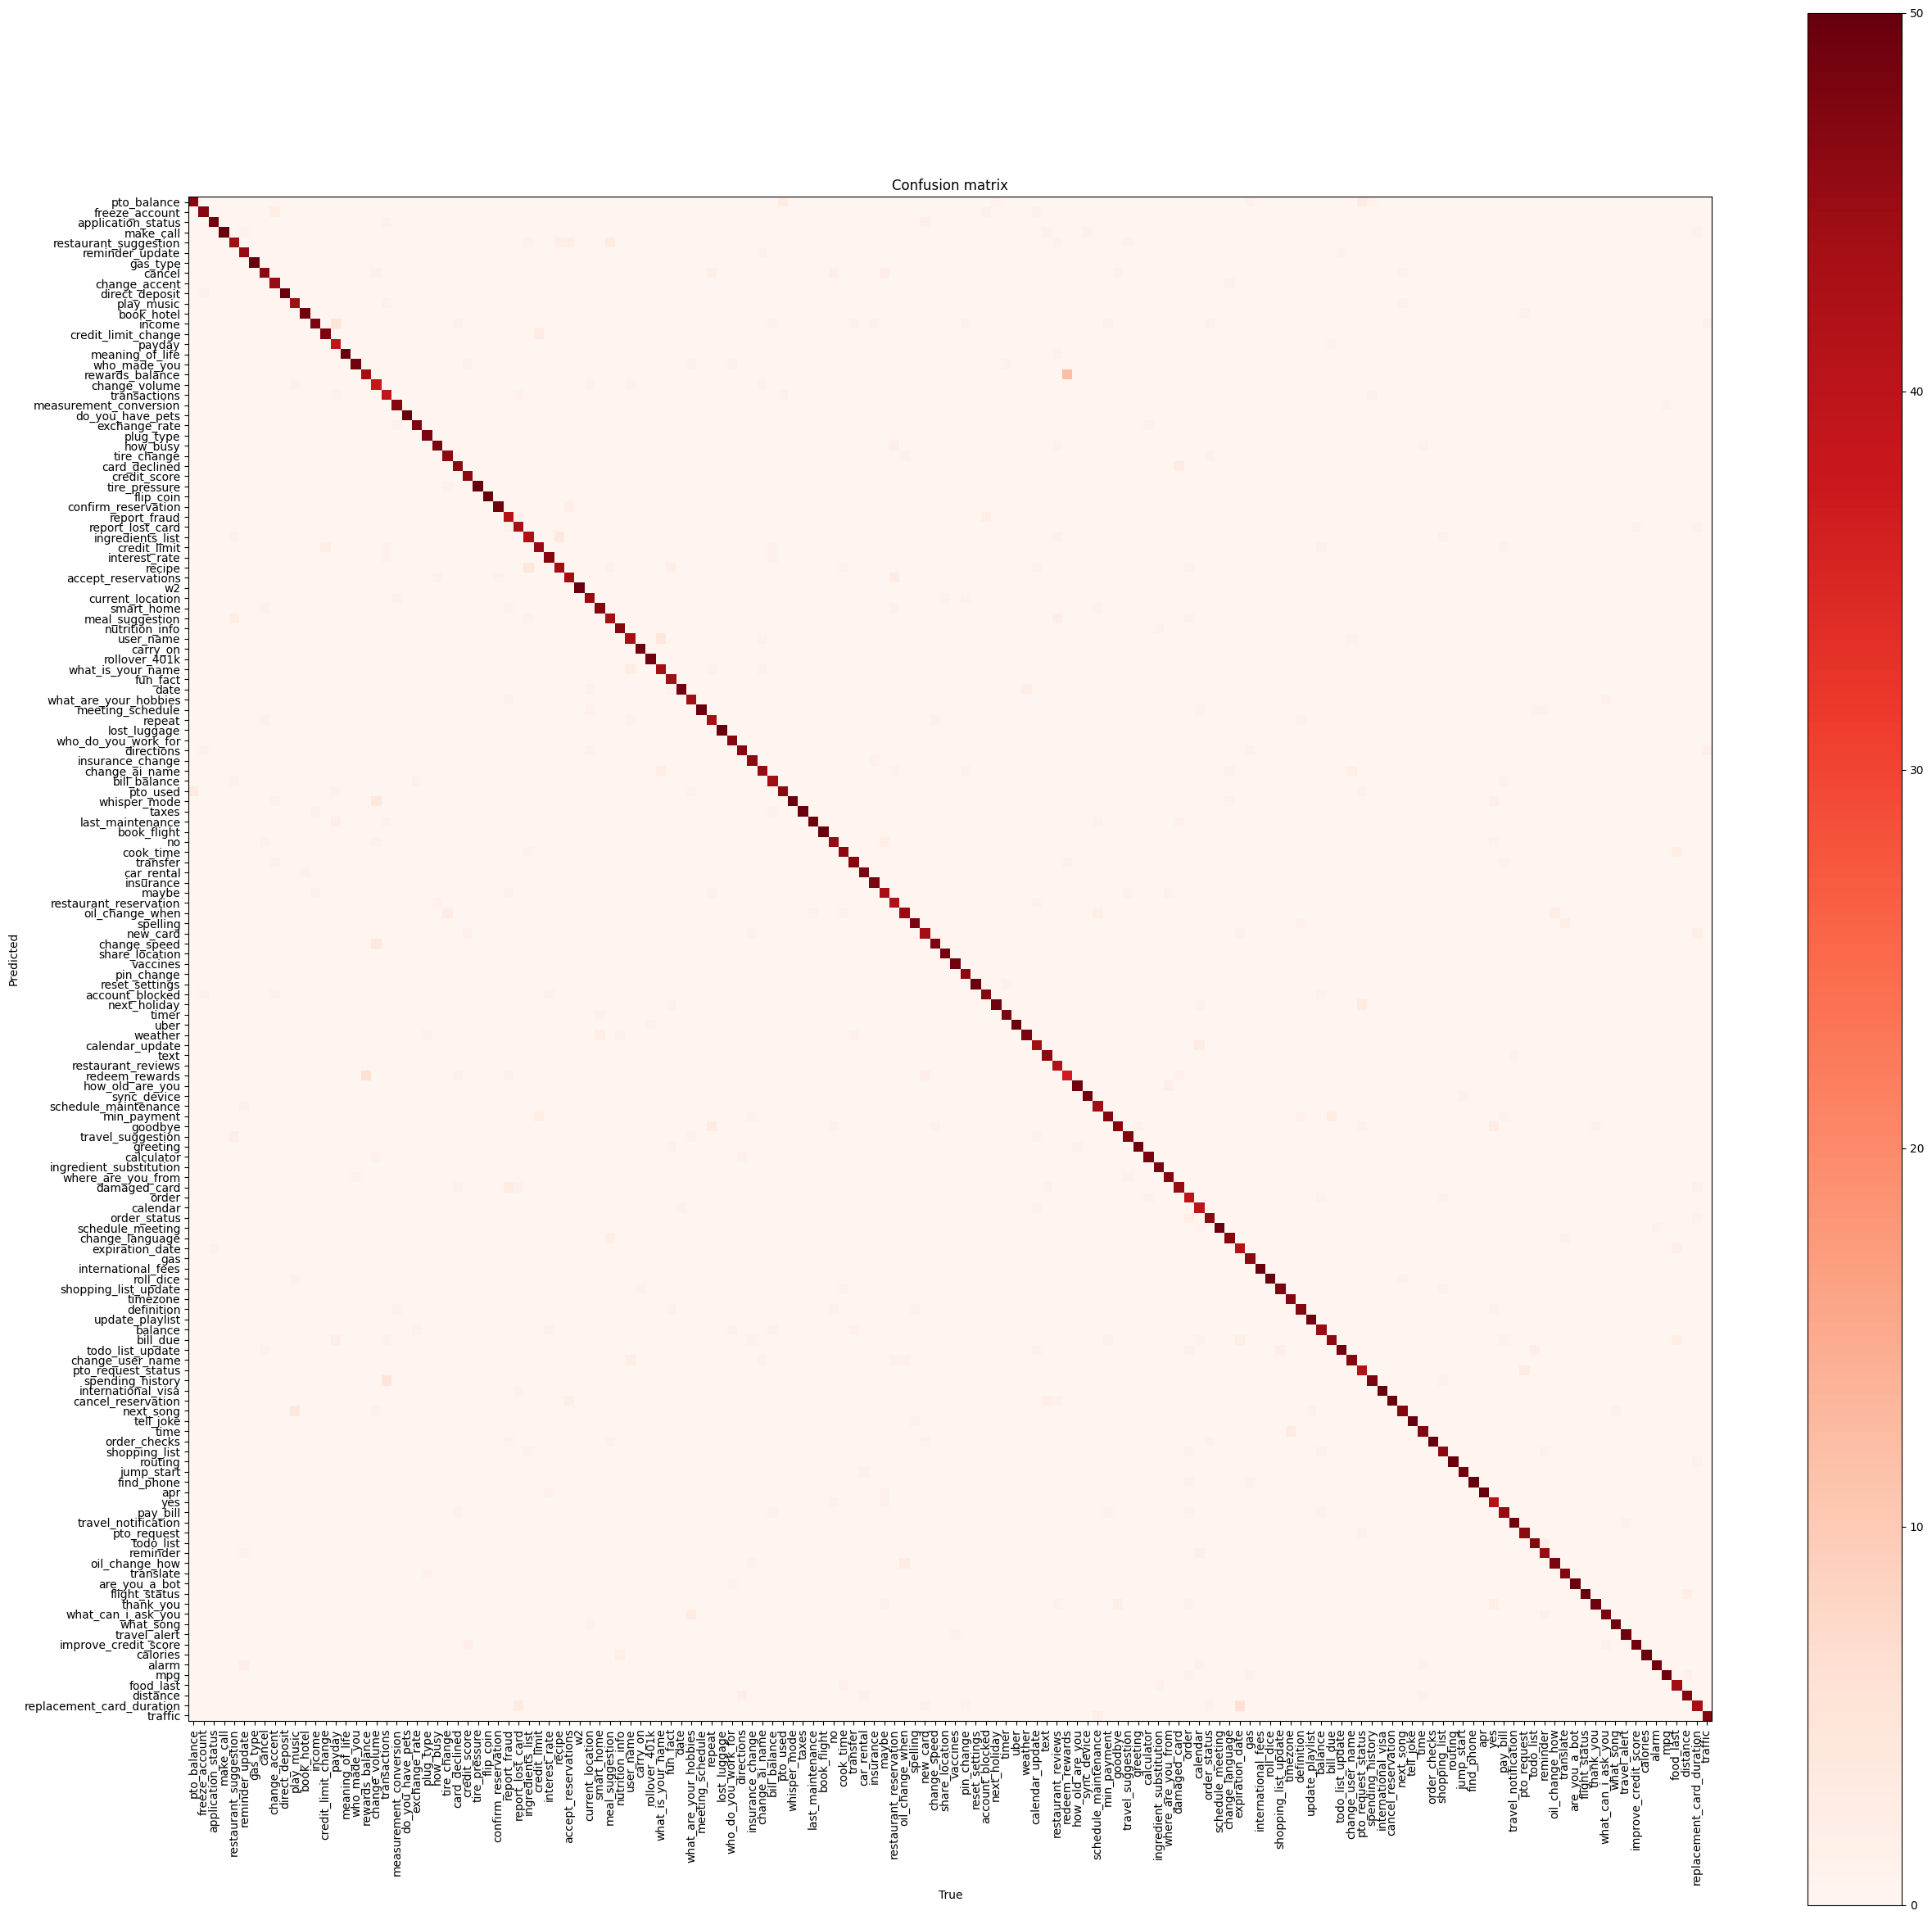

In [22]:
plot_confusion_matrix(evaluation.confusion_matrix)

### Logistic model
In this section we train the logistic model to classify the text. We will use the same optimizer as above to analyze the convergence of the model.

In [23]:
model = nn.Sequential(
    nn.Linear(X_train.shape[1], num_classes),
    nn.Softmax(dim=1)
).to(device)
optimizer = _optimizer(model.parameters(), lr=learning_rate)

100%|██████████| 50/50 [01:22<00:00,  1.65s/it, acc=0.938, train_loss=4.03, val_loss=4.09]


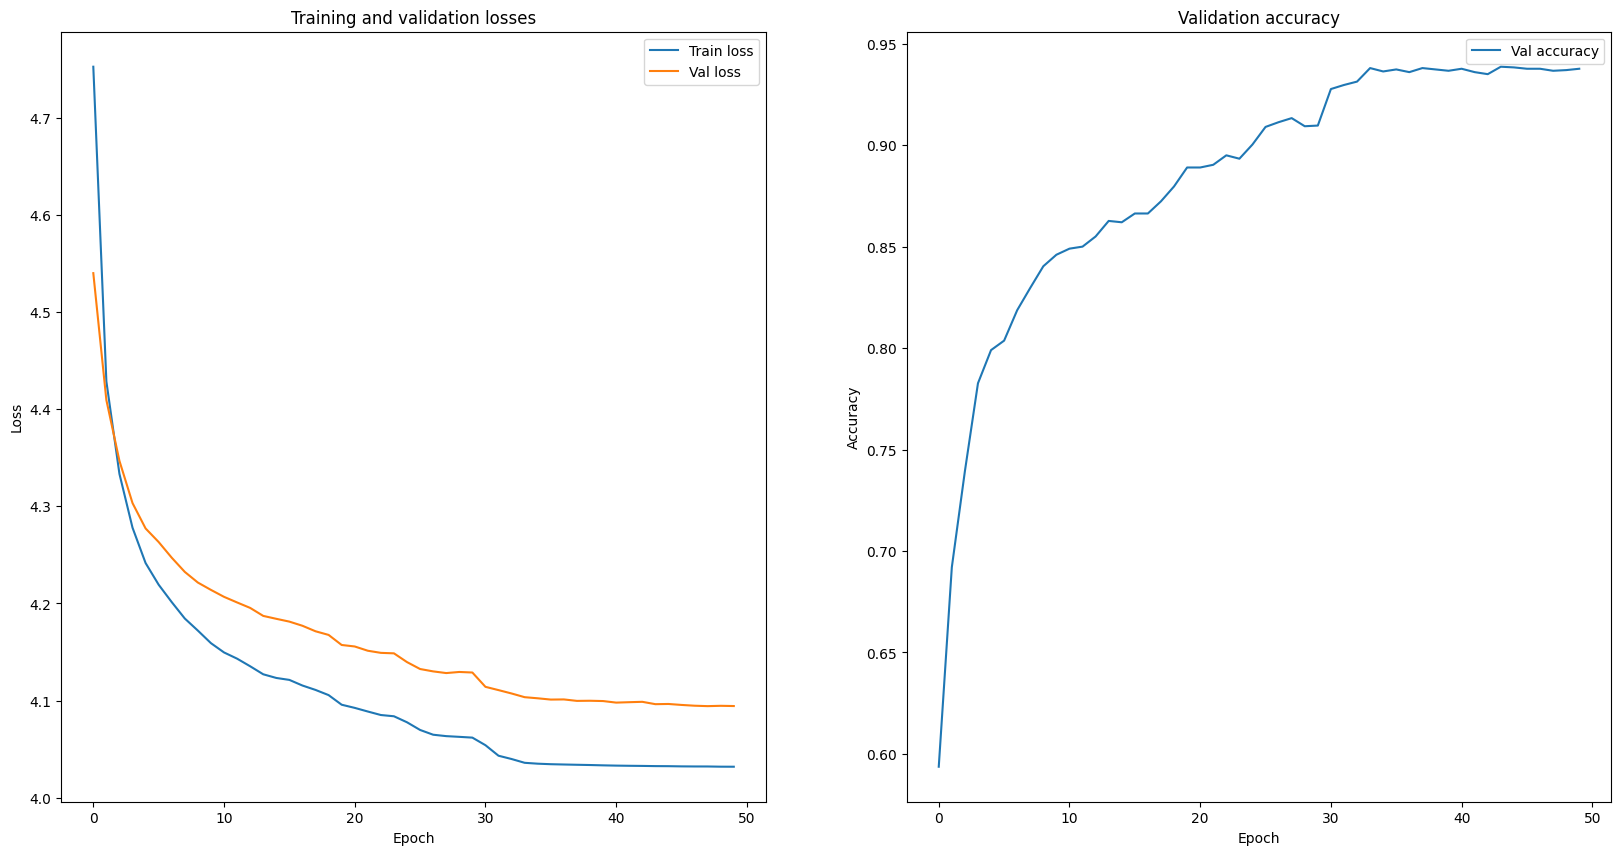

In [24]:
training = train(model=model,
                 train_dataloader=train_dataloader,
                 val_dataloader=val_dataloader,
                 optimizer=optimizer,
                 criterion=criterion,
                 scheduler=None,
                 num_epochs=num_epochs)

plot_training(training)

In [25]:
evaluation = evaluate(model, test_dataloader, criterion)
evaluation

Evaluation(accuracy=0.932, loss=4.099797679008321, confusion_matrix=array([[46.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 48.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 49., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 42.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 47.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0., 48.]]))

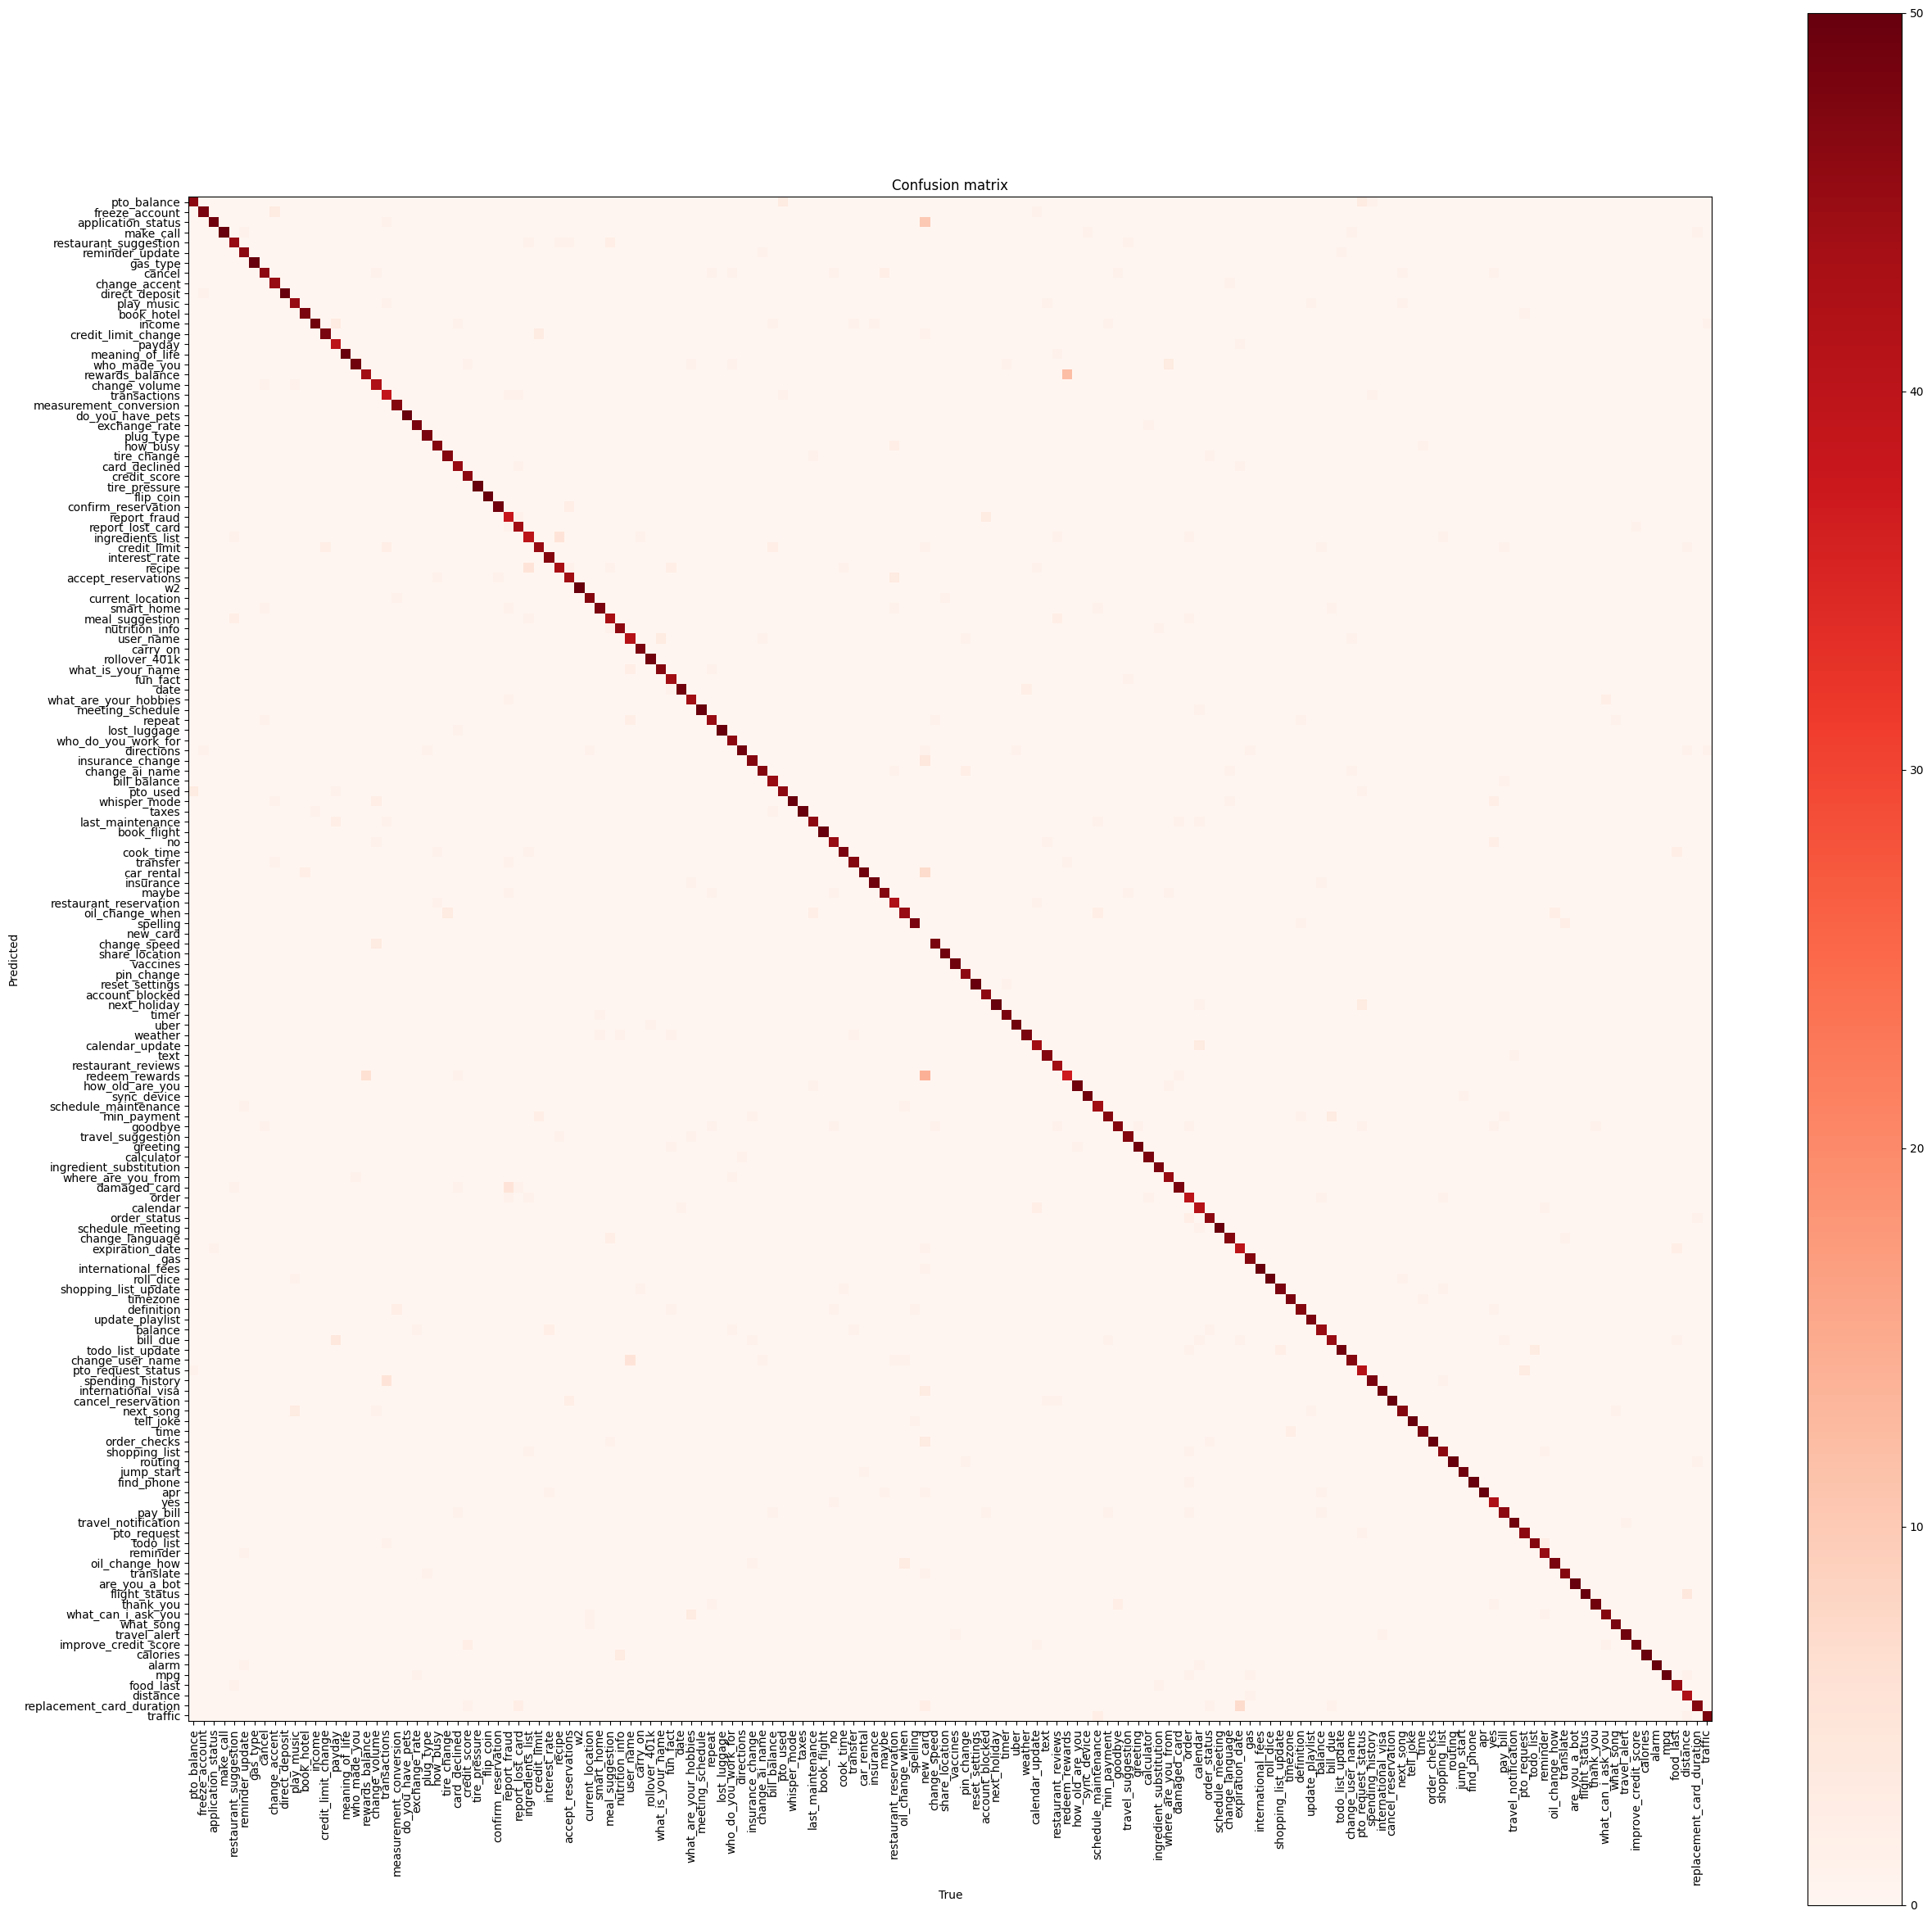

In [26]:
plot_confusion_matrix(evaluation.confusion_matrix)

### Feedforward neural network

In [27]:
hidden_size = 64

model = nn.Sequential(
    nn.Linear(X_train.shape[1], hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_classes)
).to(device)

optimizer = _optimizer(model.parameters(), lr=learning_rate)

100%|██████████| 50/50 [01:28<00:00,  1.78s/it, acc=0.915, train_loss=0.00101, val_loss=0.463]


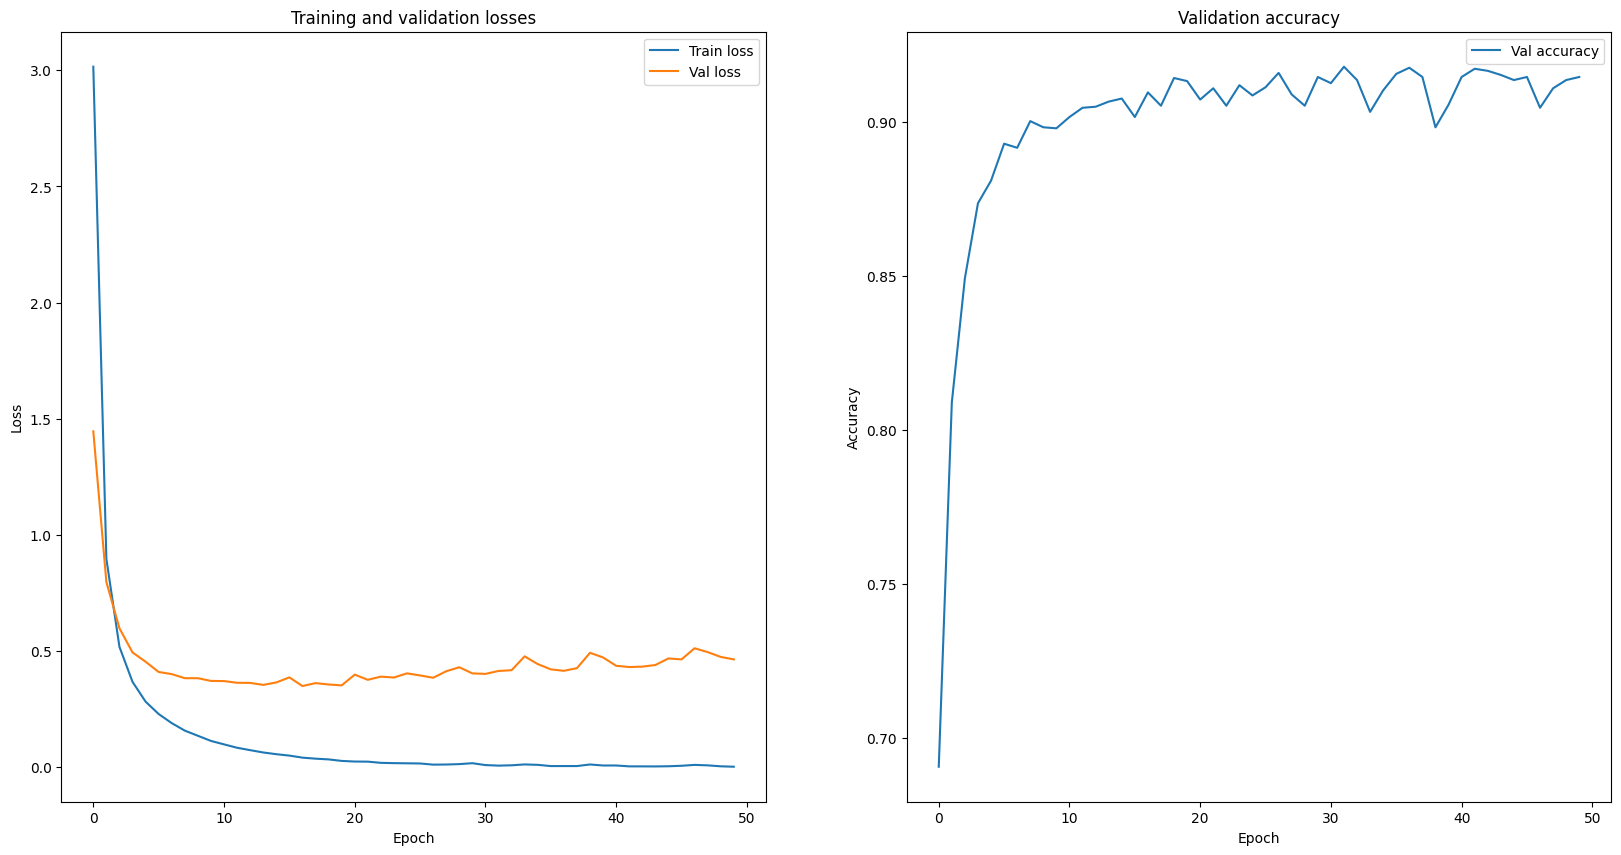

In [28]:
training = train(model=model,
                 train_dataloader=train_dataloader,
                 val_dataloader=val_dataloader,
                 optimizer=optimizer,
                 criterion=criterion,
                 scheduler=None,
                 num_epochs=num_epochs)

plot_training(training)

In [29]:
evaluation = evaluate(model, test_dataloader, criterion)
evaluation

Evaluation(accuracy=0.9098666666666667, loss=0.47523119368942135, confusion_matrix=array([[45.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 46.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 49., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 47.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 41.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 45.]]))

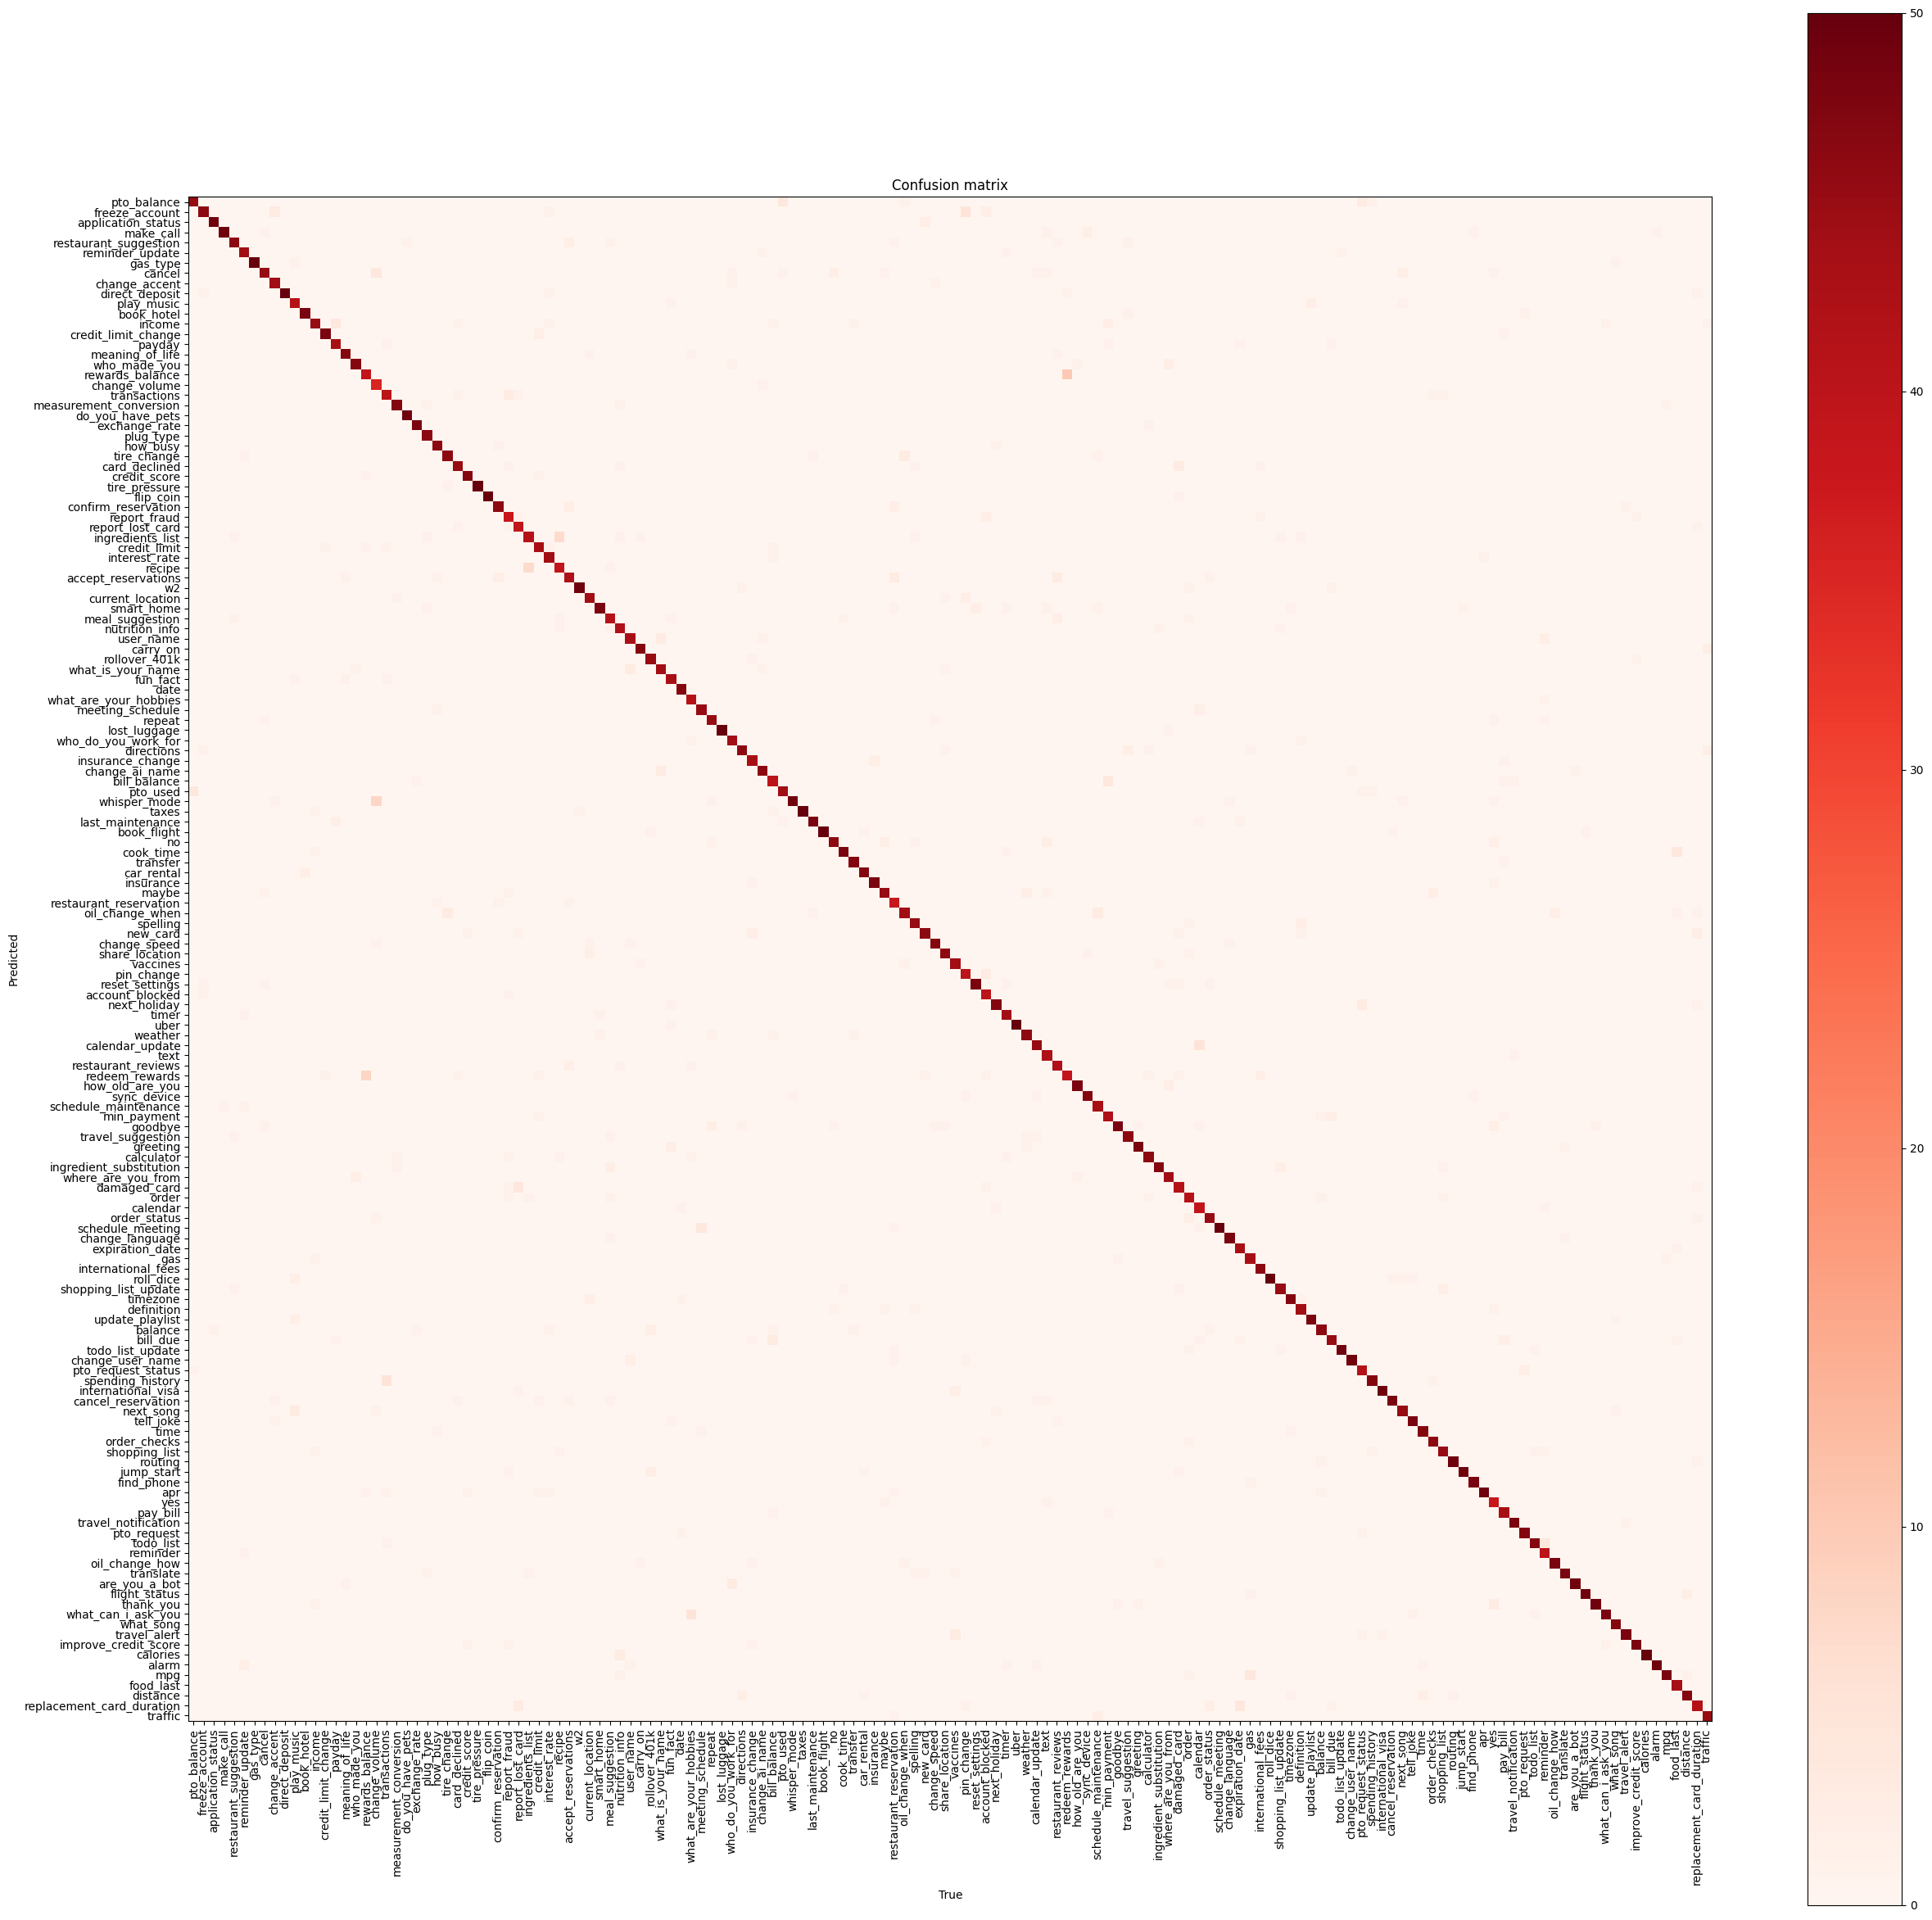

In [30]:
plot_confusion_matrix(evaluation.confusion_matrix)